# 参数初始化，并且引入相关包

In [1]:
import scipy.io as scio
import numpy as np
import torch
import os
import pickle
import time
from Model import *
from itertools import chain
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from synthetic import simulate_lorenz_96, simulate_var
from utils import build_flags, time_split, save_result, evaluate_result, count_accuracy, loss_sparsity, loss_divergence, loss_mmd

In [2]:
parser = build_flags()
args = parser.parse_args(args=[])
args.seed = 2
args.num_nodes = 264
args.dims = 1
args.threshold = 0.5
args.time_length = 500
args.time_step = 10
args.epochs = 3000
args.batch_size = 128
args.lr = 1e-3
args.weight_decay = 1e-3
args.encoder_alpha = 0.02
args.decoder_alpha = 0.02
args.beta_sparsity = 0.05 #0.25   #log_sum  #1.25是F=40,N=30的最优值
args.beta_kl = 0.01        #JS散度
args.beta_mmd = 2      #MMD
args.encoder_hidden = 20
args.decoder_hidden = 20
args.encoder_dropout = 0.1
args.decoder_dropout = 0.2

# 计算解码中的adj，并用于encoder中的初始化

In [3]:
adj = []
for idx in range(264):
    decoder_file = 'decoder' + str(idx) + '.pt'
    decoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/DLCR_PNC_emoid1', decoder_file)
    decoder_net = decoder(args.dims, args.decoder_hidden, args.time_step - 1, args.num_nodes, args.decoder_dropout, args.decoder_alpha)
    decoder_net.load_state_dict(torch.load(decoder_file, map_location='cuda:0'))
    adj.append(decoder_net.adj[idx, :])

/home/xuzijian/crf/Intrer_VAE/Model.py:20: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight.data, gain=1.414)


In [4]:
init_adj_1 = torch.cat([temp.unsqueeze(0) for temp in adj], dim=0)
init_adj_1 = init_adj_1.clone().detach()
print(init_adj_1.shape)

torch.Size([264, 264])


In [5]:
adj = []
for idx in range(264):
    decoder_file = 'decoder' + str(idx) + '.pt'
    decoder_file = os.path.join('/home/xuzijian/crf/Intrer_VAE_result/DLCR_PNC_emoid4', decoder_file)
    decoder_net = decoder(args.dims, args.decoder_hidden, args.time_step - 1, args.num_nodes, args.decoder_dropout, args.decoder_alpha)
    decoder_net.load_state_dict(torch.load(decoder_file, map_location='cuda:0'))
    adj.append(decoder_net.adj[idx, :])

In [6]:
init_adj_4 = torch.cat([temp.unsqueeze(0) for temp in adj], dim=0)
init_adj_4 = init_adj_4.clone().detach()
print(init_adj_4.shape)

torch.Size([264, 264])


In [7]:
init_adj_1 = torch.sigmoid(init_adj_1)
init_adj_4 = torch.sigmoid(init_adj_4)

In [41]:
result1, _ = evaluate_result(np.eye(264), init_adj_1.detach().numpy(), 0.5)
result4, _ = evaluate_result(np.eye(264), init_adj_4.detach().numpy(), 0.5)

In [8]:
print(init_adj_1)

tensor([[1.0000, 0.6247, 0.5446,  ..., 0.4910, 0.4896, 0.4683],
        [0.6093, 1.0000, 0.5095,  ..., 0.4660, 0.5013, 0.4927],
        [0.5092, 0.5087, 1.0000,  ..., 0.4975, 0.5104, 0.4884],
        ...,
        [0.5074, 0.4953, 0.5081,  ..., 1.0000, 0.5058, 0.5124],
        [0.4905, 0.4672, 0.5337,  ..., 0.5120, 1.0000, 0.4933],
        [0.4927, 0.5067, 0.4971,  ..., 0.5191, 0.5044, 0.9999]])


In [9]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

<Axes: >

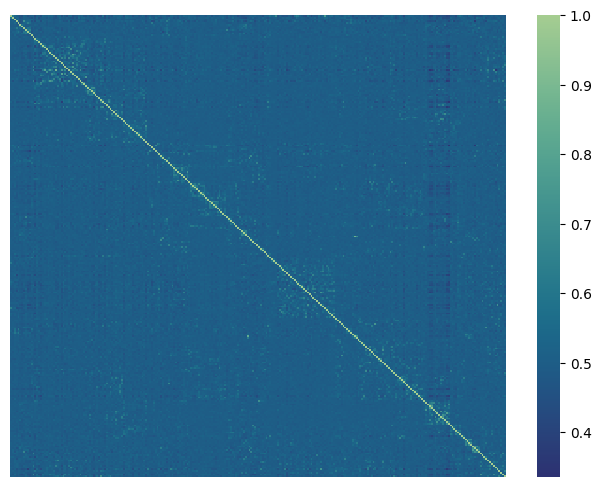

In [10]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(data=init_adj_1, cmap='crest_r', xticklabels=False, yticklabels=False)


<Axes: >

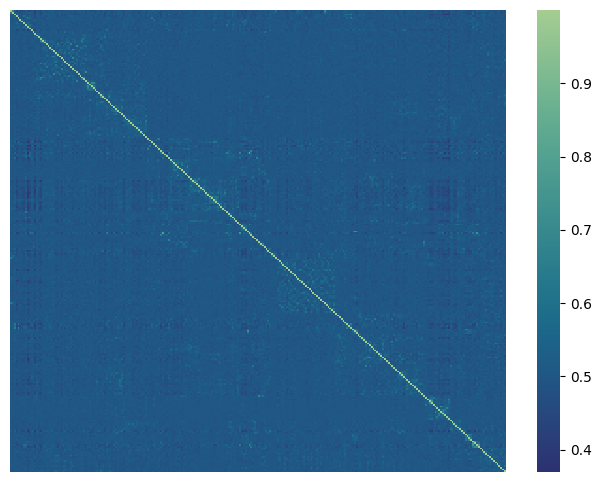

In [11]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(data=init_adj_4, cmap='crest_r', xticklabels=False, yticklabels=False)

# 计算Pearson相关系数的矩阵，并进行t检验

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from utils_bio import PCC, similarity_evaluate, directed_connection_analysis, roi2rsn, roi2rsn_weight, tTest

np.random.seed(42)

In [2]:
emoid1 = np.load('/home/xuzijian/crf/Intrer_VAE/PNC_SPM_emoid1.npy')
emoid4 = np.load('/home/xuzijian/crf/Intrer_VAE/PNC_SPM_emoid4.npy')
PCC1 = PCC(emoid1)
# PCC1 = PCC1.mean(axis=0)
PCC4 = PCC(emoid4)
# PCC4 = PCC4.mean(axis=0)

<Axes: >

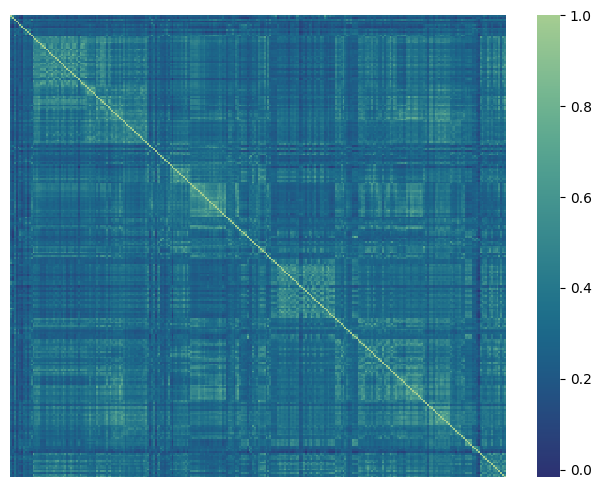

In [5]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(data=PCC1, cmap='crest_r', xticklabels=False, yticklabels=False)


<Axes: >

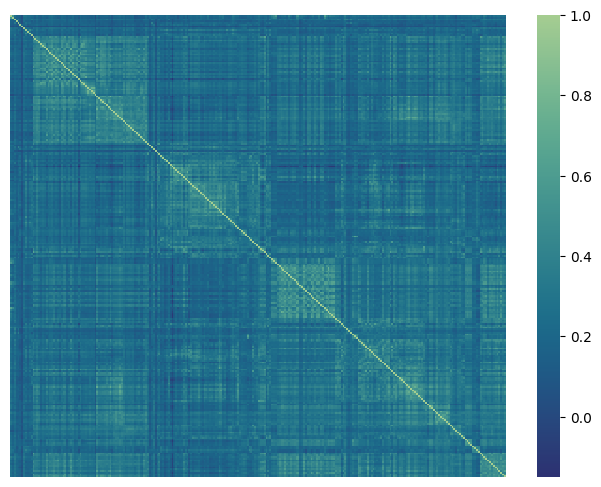

In [6]:
fig = plt.figure(figsize=(8,6))
sns.heatmap(data=PCC4, cmap='crest_r', xticklabels=False, yticklabels=False)


In [13]:
result = tTest(PCC1, PCC4)
print(result.shape)

/home/xuzijian/crf/Intrer_VAE/utils_bio.py:43: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t, p = stats.ttest_ind(data1[:, i, j], data2[:, i, j], equal_var=flag)


(264, 264)


In [14]:
print(sum(sum(result)))

39822


In [15]:
print(PCC1[:, 1, 0].shape)

(222,)


## t检验的部分，检测均值是否是相等的

In [16]:
from scipy import stats
leneve = stats.levene(PCC1[:, 1, 0], PCC4[:, 1, 0])
print(leneve)

LeveneResult(statistic=0.6455652330608614, pvalue=0.42215289561047464)
